In [1]:
# Libraries

import pandas as pd
import sqlite3
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# 1. Setup Path
DB_PATH = "../data/processed/HVT_Analysis_Final.db"
conn = sqlite3.connect(DB_PATH)

# 2. Load the Physician_Nexus_Geographic' table
df = pd.read_sql("SELECT * FROM Physician_Nexus_Geographic", conn)
conn.close()

# 3. VERIFICATION 
print(f"Geographic Intelligence active for {len(df)} unique physicians.")
print(f"Columns: {df.columns.tolist()}")

Geographic Intelligence active for 76214 unique physicians.
Columns: ['full_name', 'specialty', 'id', 'city', 'state', 'segment_name', 'commercial_spend', 'research_spend', 'total_spend', 'primary_manufacturer', 'influence_ratio', 'mfg_loyalty_pct', 'log_total_spend', 'lead_score']


In [3]:
# Calculate average brand loyalty per city to find "Vulnerable" markets
city_loyalty = df.groupby(['city', 'state'])['mfg_loyalty_pct'].mean().reset_index()

# Find Hubs where no single brand dominates (Loyalty < 50%)
battleground_hubs = city_loyalty[city_loyalty['mfg_loyalty_pct'] < 50].sort_values(by='mfg_loyalty_pct')

print("TOP BATTLEGROUND HUBS (Expansion Opportunities):")
display(battleground_hubs.head(5))

TOP BATTLEGROUND HUBS (Expansion Opportunities):


,city,state,mfg_loyalty_pct
296,Beltsville,MD,0.277085
228,Basalt,CO,20.433521
1019,District Of Columbia,DC,22.254261
3692,Sharon,MA,22.815276
4043,Tipton,MI,32.336423


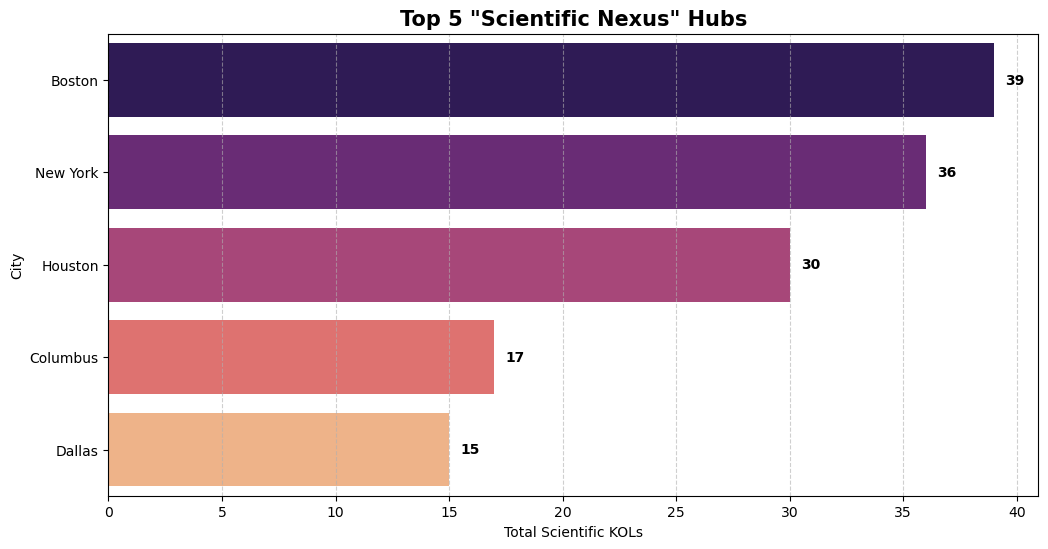

In [4]:
# 1. Filter for 'Scientific KOLs' and count the top 5 cities
city = df[df['segment_name'] == 'Scientific KOLs']['city'].value_counts().head(5)

# 2. Now run plotting code
plt.figure(figsize=(12, 6))
sns.barplot(
    x=city.values, 
    y=city.index, 
    palette='magma',
    hue=city.index,
    legend=False
)

plt.title('Top 5 "Scientific Nexus" Hubs', fontsize=15, fontweight='bold')
plt.xlabel('Total Scientific KOLs')
plt.ylabel('City')
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Adding data labels 
for i, v in enumerate(city.values):
    plt.text(v + 0.5, i, str(v), color='black', va='center', fontweight='bold')

plt.show()

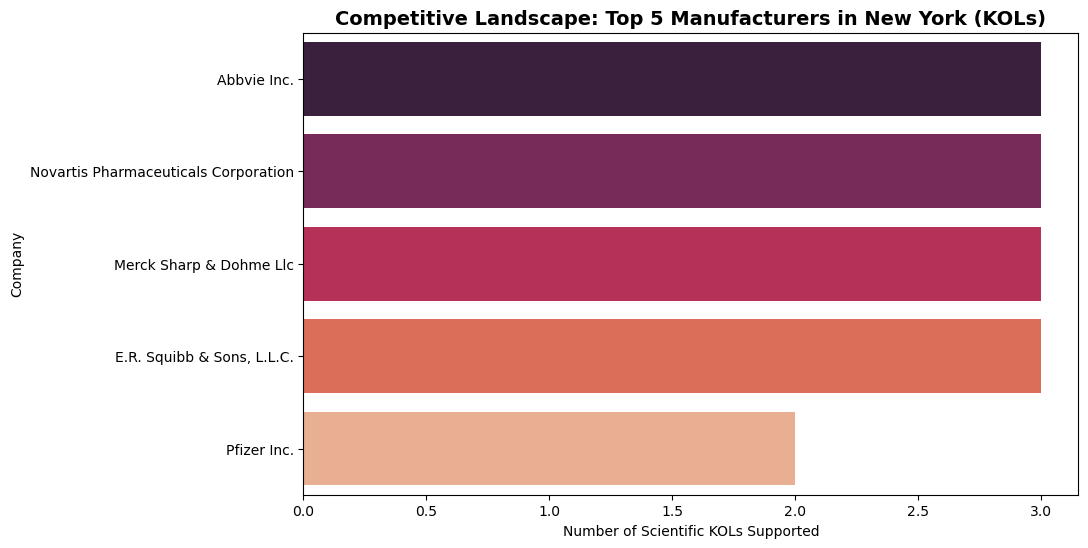

In [5]:
# --- NEW YORK  ---
# Filter for KOLs in the #1 City
ny_kols = df[(df['city'] == 'New York') & (df['segment_name'] == 'Scientific KOLs')]

# Count by Manufacturer
ny_leaders = ny_kols['primary_manufacturer'].value_counts().head(5).reset_index(name='count')

plt.figure(figsize=(10, 6))
sns.barplot(data=ny_leaders, x='count', y='primary_manufacturer', hue='primary_manufacturer', palette='rocket', legend=False)
plt.title('Competitive Landscape: Top 5 Manufacturers in New York (KOLs)', fontsize=14, fontweight='bold')
plt.xlabel('Number of Scientific KOLs Supported')
plt.ylabel('Company')
plt.show()

In [6]:
# --- 1. THE HVT LEAD SCORE (PRIORITIZATION) ---
# Initialize scaler
scaler = MinMaxScaler(feature_range=(0, 100))

# Use .flatten() to turn the 2D output into a simple 1D list
# This prevents the "Broadcasting" error and saves RAM
scaled_spend = scaler.fit_transform(df[['log_total_spend']]).flatten()

# Calculate Lead Score: 70% Scale (Spend) + 30% Science (Influence)
df['lead_score'] = (scaled_spend * 0.7) + (df['influence_ratio'] * 30)

# --- 2. THE COMPETITIVE GAP ANALYSIS ---
# Calculate average loyalty per city
city_loyalty = df.groupby(['city', 'state'])['mfg_loyalty_pct'].mean().reset_index()

# Filter for "Battleground Hubs" where doctors are NOT yet locked into one brand
battleground_hubs = city_loyalty[city_loyalty['mfg_loyalty_pct'] < 50].sort_values(by='mfg_loyalty_pct')

print("Strategy Upgraded: Lead Scores calculated and Battleground Hubs identified.")
print(f"Top Lead Score in Dataset: {df['lead_score'].max():.2f}")

Strategy Upgraded: Lead Scores calculated and Battleground Hubs identified.
Top Lead Score in Dataset: 89.23


In [7]:
# --- THE ELITE 10: NATIONAL RANKING ---
# Sorting by your new Lead Score (70% Spend / 30% Influence)
leaderboard = df[[
    'full_name', 'specialty', 'city', 'state', 
    'segment_name', 'lead_score', 'total_spend'
]].sort_values(by='lead_score', ascending=False)

print("PHARMAREACH STRATEGIC LEADERBOARD")
display(leaderboard.head(10))

PHARMAREACH STRATEGIC LEADERBOARD


,full_name,specialty,city,state,segment_name,lead_score,total_spend
45519,Matthew Budoff,Cardiology,Torrance,CA,Scientific KOLs,89.226926,1523011.03
66049,Sibyl Wray,Neurology,Knoxville,TN,Scientific KOLs,88.859972,1370282.05
38567,Khaldoun Almhanna,Oncology,Tampa,FL,Scientific KOLs,87.501387,1211074.57
21219,Erica Mayer,Oncology,Boston,MA,Scientific KOLs,87.345862,1094695.38
56003,Praful Ravi,Oncology,Boston,MA,Scientific KOLs,86.981103,892339.25
75592,Yucai Wang,Oncology,Rochester,MN,Scientific KOLs,84.949528,600576.86
27695,Inhye Ahn,Oncology,Boston,MA,Scientific KOLs,84.651337,558586.32
56220,Preet Singh,Oncology,Springfield,IL,Scientific KOLs,83.891936,445819.33
69385,Syed Naqvi,Cardiology,Houston,TX,Scientific KOLs,83.554618,408459.79
43530,Margaret Block,Oncology,Omaha,NE,Scientific KOLs,83.506259,404363.62
